# 1 <b>Prediction of PE Log-SEG Dataset</b>
---

<b><h2>Business Objective:</h2></b>

Interpret Oil & Gas reservoir characteristics and properties, to achieve better understanding of rocks for hydrocarbons reserves's estimation.

<b><h2>Project Objective:</h2></b>

Develop a data-driven model that can predict PE log along the length of the well. The data-driven model uses other available logs as features for the PE prediction.

The first part of this project uses a SEG (Society of Exploration Geophysicist) dataset and workflow based in the tutorial-paper: "Facies classification using machine learning" found in http://github.com/seg. This notebook relies on  sklearn algorithms and metrics.

The first part of the Notebook uses some of the UNAL MLDS course's Unit 1: data gathering, edition, and visualization techniques. The second part of the Notebook uses UNAL MLDS course's unit 2: Machine learning regression algorithms.

### Photoelectric factor log (PE log) measures lithology type.

### More Info: https://www.kgs.ku.edu/Publications/Bulletins/LA/06_photo.html

*   For example, PE of 1.8 indicates Sandstone and PE of 5.1 indicates Limestone.
*   PE log is used to detect lithology type.

*   PE log is not measured in each well.


### <b>Glosary</b>

**Well or Wellbore:** In drilling, the drilled hole.

**Reservoir:** An independent hydrocarbon holding rock.

**GR (Gamma Ray log):**:Uses a scintillation crystal and a photomultiplier tube to measure naturally occurring and artificially induced gamma-ray radiation. The gamma-ray radiation is a signature of the formations in a well – very useful in depth control. Used in open hole or pipe and also used to spot changes in radiation (NORM scale) and radioactive tracers. Abbreviated GR.

**Resistivity (ILD-Log10):** Measurement of a substance (or rock) to resist the flow of electric charge. Opposite of Conductance. Example: *A rock with high resistivity might contain hydrocarbons (oil or gas). Conversely a rock with low resistivity might contain salty water in it's pores.*

**Porosity (DeltaPHI):** The percentage of the rock volume that is not rock grains and could be occupied by fluids. Pores may or may not be connected.
The volume percentage of the total bulk not occupied by solid particles.

**Neutron Log(NPHI):** A log whose source emits neutrons into the formation. Neutrons interact with hydrogen nuclei resulting in an energy loss that is converted to neutron porosity. All hydrocarbons and water contain hydrogen, but the formation usually does not. The amount of hydrogen in the gas affects the reading, so gas filled porosity shows a lower log porosity than oil or water filled porosity.

**Density Log (RHOB):**One of a number of logging techniques that estimate the density of the formation.

**Neutron-Porosity (PhiND):** A computation of porosity, from a combination of neutron and porosity logs readings.

**PE (PhotoElectric Factor):** A log of photoelectric absorption properties. The log measures the photoelectric absorption factor, Pe, which is defined as (Z/10)^3.6 where Z is the average atomic number of the formation. Pe is unitless, but since it is proportional to the photoelectric cross section per electron, it is sometimes quoted in barns/electron.

**NM_M:** Non Marine to Marine environment. Fraction of a portion of rock deposited in non marine environment with respect to a portion deposited in marine environment.

**RELPOS:** Relative position.

**Facies:** A different part of the rock strata indicating a change in mineral content or deposition mechanics.


In [ ]:
# Importing the required default packages
import numpy as np
import pandas as pd

# Visualization
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.image as mpimg

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest

# Regressors
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# Ignoring the warnings
import warnings
warnings.filterwarnings("ignore")

A logging tool run in oil&Gas wells is as depicted below, these tools are capable to obtain all the required information that we work with here as columns (features) in our datasets:

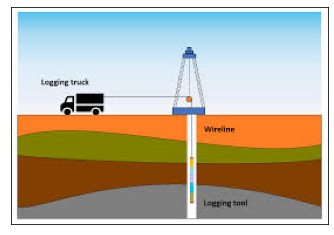

In [ ]:
plt.imshow(mpimg.imread('wireline tool.jpg'))
plt.xticks([])
plt.yticks([])
plt.show()

## 1.1 Exploring the dataset


---

First, we examine the dataset available to train the regressors which will have some of the following variables as inputs

| Variable | Definition	| Values |
| --- | --- | --- |
| Formation   | Name of rock strata               | Categorical 	|
| Well Name   | Name of Well                      | Categorical 	|
| Depth 	    | Depth of specific data (ft). 	    | Cuantitative  |
| GR          |	Gamma ray log (API) 	            | Cuantitative  |
| ILD_Log10   | Resistivity values (Ohm-m)        | Cuantitative  |
| DeltaPHI    |	Porosity difference (%).	        | Cuantitative  |
| PHIND       |	Porosity from Neutron Density (%) | Cuantitative  |
| PE          |	Photoelectric factor              | Cuantitative  |
| NM_M        |	Non Marine to marine ratio        | Cuantitative  |
| RELPOS      |	Relative Position                 | Cuantitative  |
| Facies      |	Rock type classification          | Categorical   |

It has been previously established from Project-1 SEGDataset-Facies prediction, that some variables are categorical, and that some others are not important (at least from the random forest regressor standpoint), therefore these features will not be considered in this notebook.

In [ ]:
# Importing the data from SEGData, and dropping the undesired features
df = pd.read_excel('SEGData_Project.xlsx',index_col='Depth')
df = df.drop(['Unnamed: 0', 'NM_M', 'RELPOS', 'Well Name', 'Formation', 'Facies'], axis=1)
df

,GR,ILD_log10,DeltaPHI,PHIND,PE
Depth,,,,,
2808.0,66.276,0.630,3.300,10.650,3.591
2808.5,77.252,0.585,6.500,11.950,3.341
2809.0,82.899,0.566,9.400,13.600,3.064
2809.5,80.671,0.593,9.500,13.250,2.977
2810.0,75.971,0.638,8.700,12.350,3.020
...,...,...,...,...,...
3158.5,86.078,0.554,5.040,16.150,3.161
3159.0,88.855,0.539,5.560,16.750,3.118
3159.5,90.490,0.530,6.360,16.780,3.168


In [ ]:
# Showing the descriptive statistics of the data
df.describe()

# there is nothing anamolous/strange in the descriptive statistics of the data

,GR,ILD_log10,DeltaPHI,PHIND,PE
count,830.00000,830.000000,830.000000,830.000000,830.000000
mean,57.61173,0.666312,2.851964,11.655277,3.654178
std,27.52774,0.288367,3.442074,5.190236,0.649793
min,12.03600,-0.468000,-8.900000,1.855000,2.113000
25%,36.77325,0.541000,0.411250,7.700000,3.171500
50%,58.34450,0.675000,2.397500,10.950000,3.515500
75%,73.05150,0.850750,4.600000,14.793750,4.191500
max,220.41300,1.507000,16.500000,31.335000,6.321000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 830 entries, 2808.0 to 3160.5
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GR         830 non-null    float64
 1   ILD_log10  830 non-null    float64
 2   DeltaPHI   830 non-null    float64
 3   PHIND      830 non-null    float64
 4   PE         830 non-null    float64
dtypes: float64(5)
memory usage: 38.9 KB


## 1.2 Data Visualization


---



We can observe each of the kde distributions for the logs, using a violin plot: there are possible outliers for both GR and ILD_log10 logs. The features are scaled, so they can be compared in a violinplot

Text(0.5, 1.0, 'Well Logs distribution')

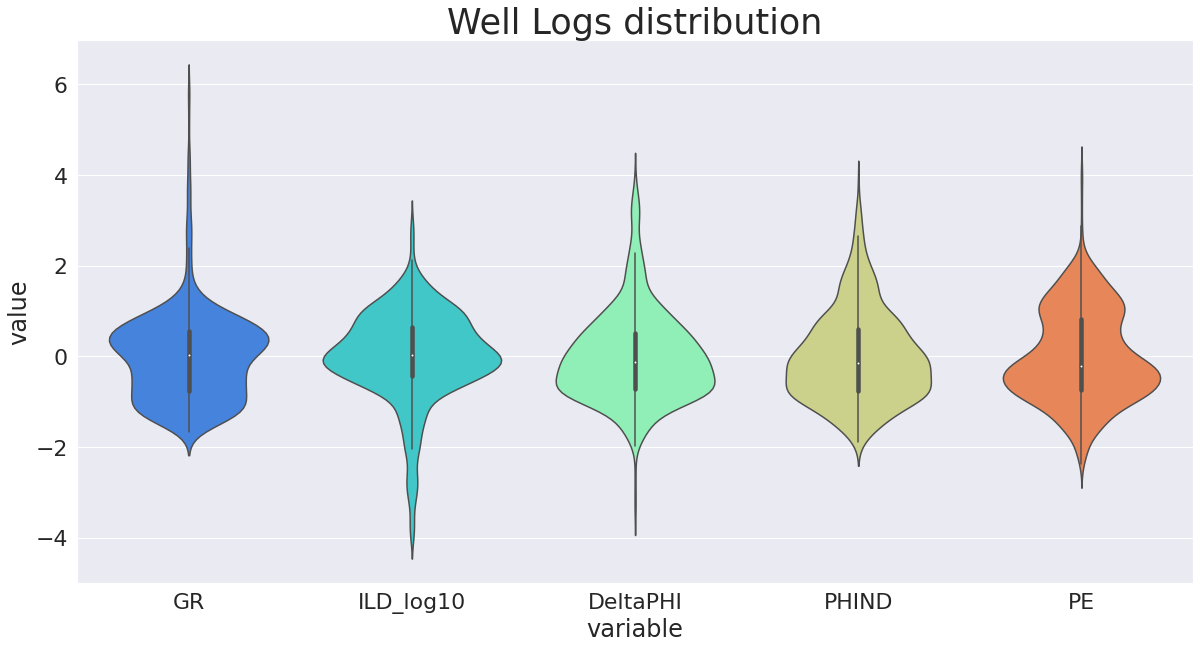

In [ ]:
plt.figure(figsize = (20,10))
sns.set(font_scale = 2)

scaler = StandardScaler().fit(df)
scaled_features = scaler.transform(df)

# Creating dataframe for the scaled features
df_s = pd.DataFrame(scaled_features,columns=['GR','ILD_log10','DeltaPHI','PHIND','PE'])

sns.violinplot(x="variable", y="value",data=pd.melt(df_s),palette='rainbow')
plt.title("Well Logs distribution", fontsize = 35)

We observe negative values for Log-resistivity data, which seems ok if rawdata resistivity is between 0-1. As for DeltaPHI, we hypotesize negative values are due to possible gas Zones (cross-over), where the difference between Density porosity and neutron porosity might be negative.

In [ ]:
%matplotlib inline
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None
mpl.rcParams.update(mpl.rcParamsDefault)

def make_log_plot1(logs):
    #make sure logs are sorted by depth
    logs.sort_index(inplace=True)
    logs.Depth = np.array(logs.index)
    ztop=logs.Depth.min(); zbot=logs.Depth.max()

    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-k')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '--b')
    ax[3].plot(logs.PHIND, logs.Depth, '-r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')

    for i in range(len(ax)):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_xlabel("GR",fontsize=10)
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10",fontsize=10)
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI",fontsize=10)
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND",fontsize=10)
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE",fontsize=10)
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())

    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]);

    ax[0].set_xticklabels([0,100,200],fontsize=8);ax[1].set_xticklabels([0,2,5],fontsize=8);
    ax[2].set_xticklabels([0,5,15],fontsize=8);ax[3].set_xticklabels([0,15,30],fontsize=8);
    ax[4].set_xticklabels([0,2,5],fontsize=8);

    f.suptitle('Well: SEG_DATA WELL', fontsize=14,y=0.94)

We Show well logs for well as follows below

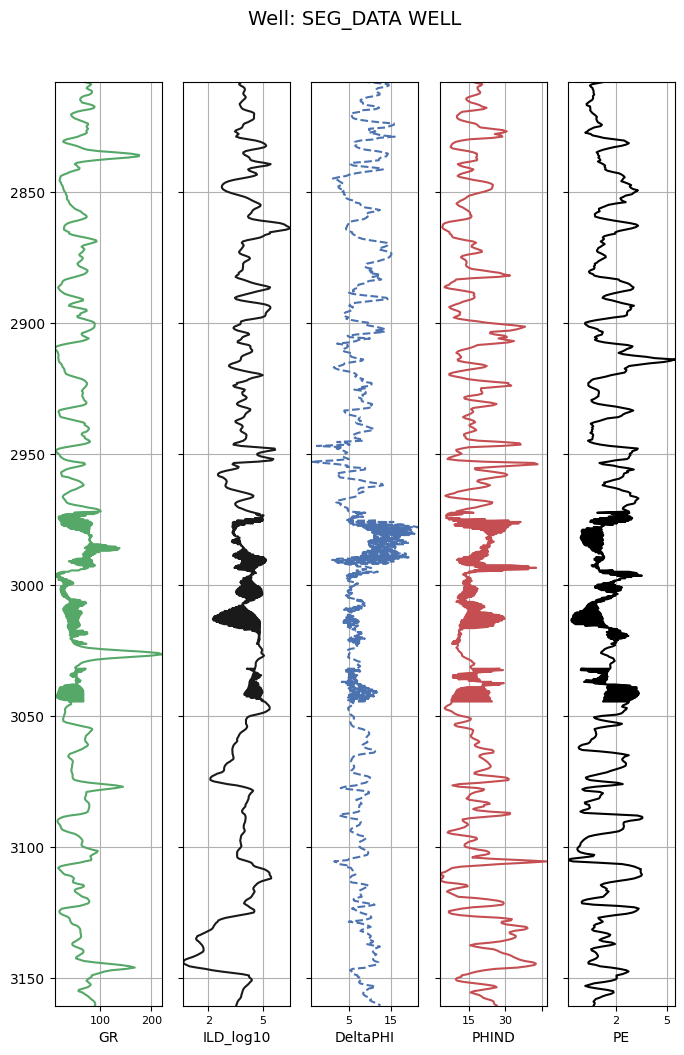

In [ ]:
make_log_plot1(df)

We can visualize how variables relate to each other, using pairsplot:

+ Very nice inverse linear trend are observed between resistivity (ILD-Log10) and porosity (PHIND), indicating the less porous rocks (carbonates) might contain the target hydrocarbons in this very particular geologic setting.

+ Also a slight linear trend can be observed betwen PE and porosity. Carbonates exhibit higher values of PE (this is expected).

+ We could draw many similar observations from these plots, some of these very obvious for a geologist expert.

For more insights on logs corresponding to facies, refer to notebook SEGDataset-FaciesClassification.


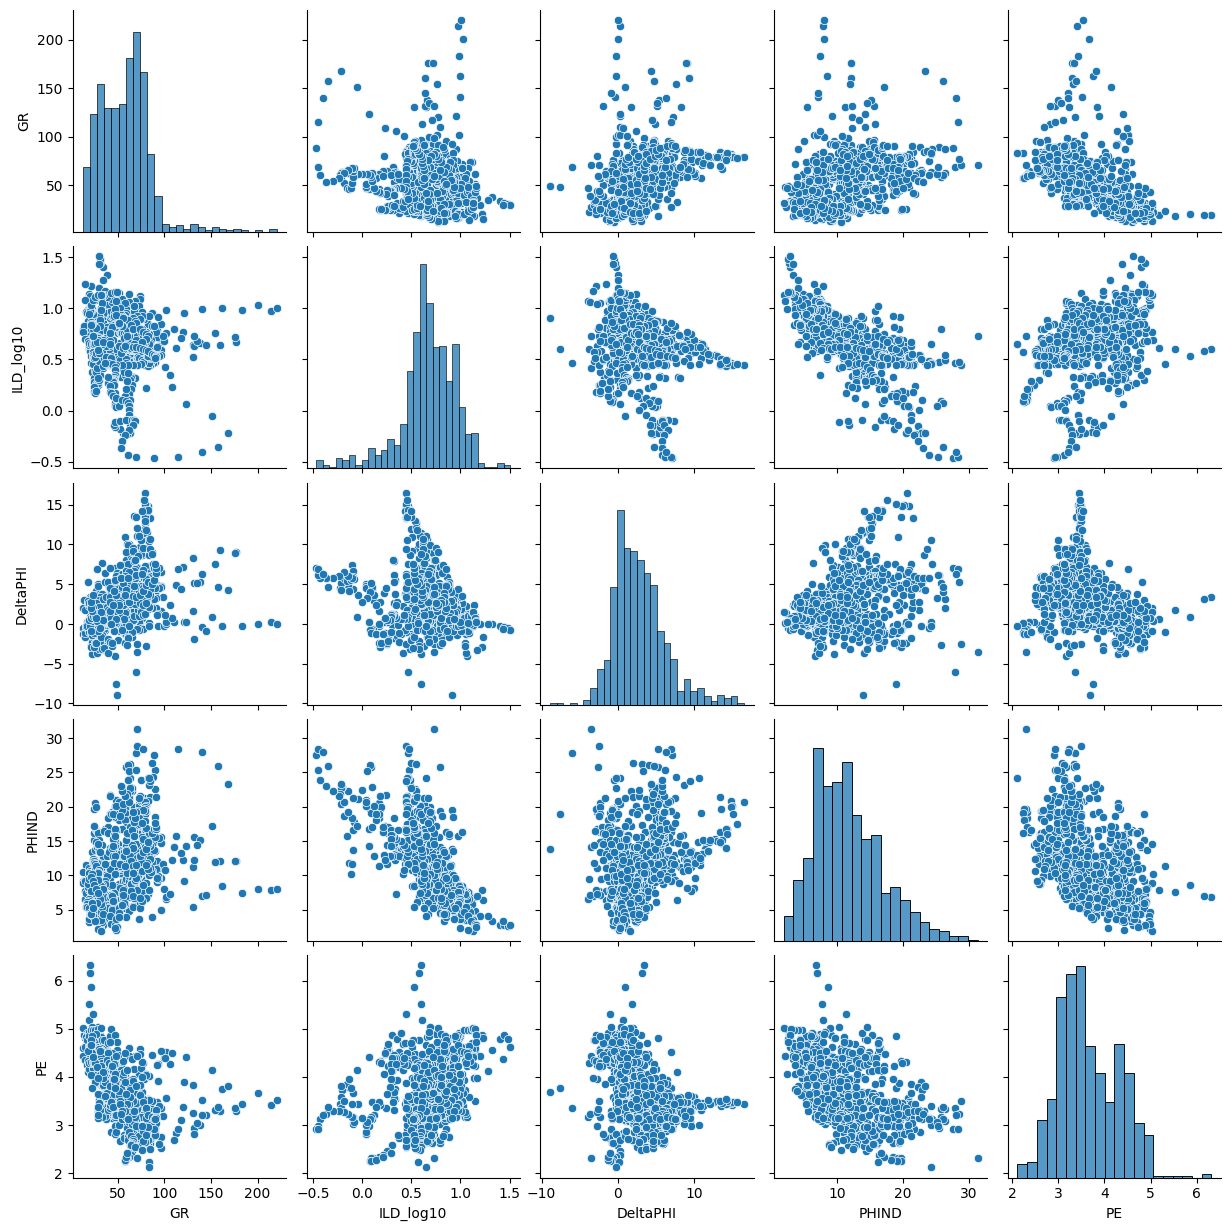

In [ ]:
# Creating new dataframe just to show the cross-plot
ndf = pd.read_excel('SEGData_Project.xlsx',index_col=0)
ndf = ndf.drop(['Depth', 'NM_M', 'RELPOS', 'Well Name', 'Formation', 'Facies'], axis=1)

# Generating the cross-plot of the data
sns.pairplot(ndf)

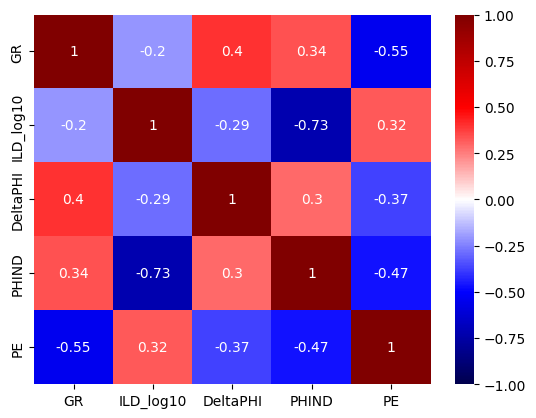

In [ ]:
# calculate the correlation matrix to generate Pearson correlation map
corr_pearson = df.corr(method='pearson')

# plot Pearson correlation heatmap
sns.heatmap(corr_pearson, xticklabels=corr_pearson.columns, yticklabels=corr_pearson.columns,center=0, vmin=-1, vmax=1, cmap='seismic', annot=True)

# We can deduce that our target "PE" has no high collinearity with the features

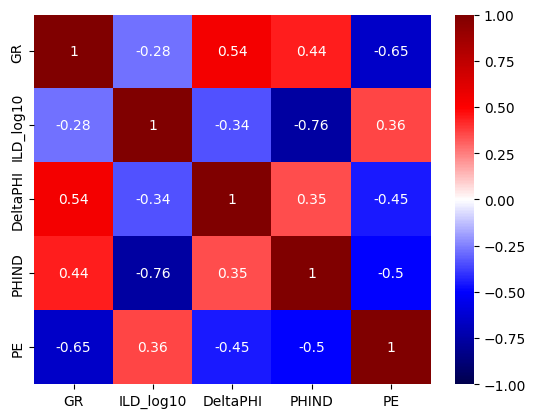

In [ ]:
# calculate the correlation matrix to generate Pearson correlation map
corr_spearman = df.corr(method='spearman')

# plot Pearson correlation heatmap
sns.heatmap(corr_spearman, xticklabels=corr_spearman.columns, yticklabels=corr_spearman.columns,center=0, vmin=-1, vmax=1, cmap='seismic', annot=True)

# We can deduce that our target "PE" has weak monotonic association with the features

## 1.3 Data Preprocessing

---



We divide the training data into training features and target:

In [ ]:
# Identifying the features
Feature = df.drop(['PE'], axis=1)
Feature

,GR,ILD_log10,DeltaPHI,PHIND
Depth,,,,
2808.0,66.276,0.630,3.300,10.650
2808.5,77.252,0.585,6.500,11.950
2809.0,82.899,0.566,9.400,13.600
2809.5,80.671,0.593,9.500,13.250
2810.0,75.971,0.638,8.700,12.350
...,...,...,...,...
3158.5,86.078,0.554,5.040,16.150
3159.0,88.855,0.539,5.560,16.750
3159.5,90.490,0.530,6.360,16.780


In [ ]:
# Identifying the target
Target = df.drop(['GR','ILD_log10','DeltaPHI','PHIND'], axis=1)
Target

,PE
Depth,
2808.0,3.591
2808.5,3.341
2809.0,3.064
2809.5,2.977
2810.0,3.020
...,...
3158.5,3.161
3159.0,3.118
3159.5,3.168


### 1.3.1 Splitting Features and Targets

The dataset will be splitted into training and testing data using 25% of data for validation. We use a random state for reproducibility purposes

In [ ]:
# Splitting the data into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(Feature, Target, random_state=620, test_size=0.25)

### 1.3.2. Outlier Detection
 Some possible outliers were detected in the pairsplots previously. We use an isolation Forest class, to take care of this possible outliers. We set contamination to 5% of the data.

In [ ]:
# Applying isolation forest to detect outliers (Assuming 5% contamination)
iforest = IsolationForest(n_estimators=500, contamination=0.05)
iforest.fit(X_train)

IsolationForest(contamination=0.05, n_estimators=500)

In [ ]:
# Removing the outliers from the training and testing dataset
X_train_i = X_train[iforest.predict(X_train)==1]
y_train_i = y_train[iforest.predict(X_train)==1]
X_test_i = X_test[iforest.predict(X_test)==1]
y_test_i = y_test[iforest.predict(X_test)==1]

In [ ]:
# Number of Outliers
np.shape(X_train)[0] - np.shape(X_train_i)[0]

32

In [ ]:
X_df = np.vstack([X_train_i,X_test_i])
Y_df = np.vstack([y_train_i,y_test_i])
df1 = np.hstack([X_df,Y_df])

df1 = pd.DataFrame(df1,columns=df.columns)

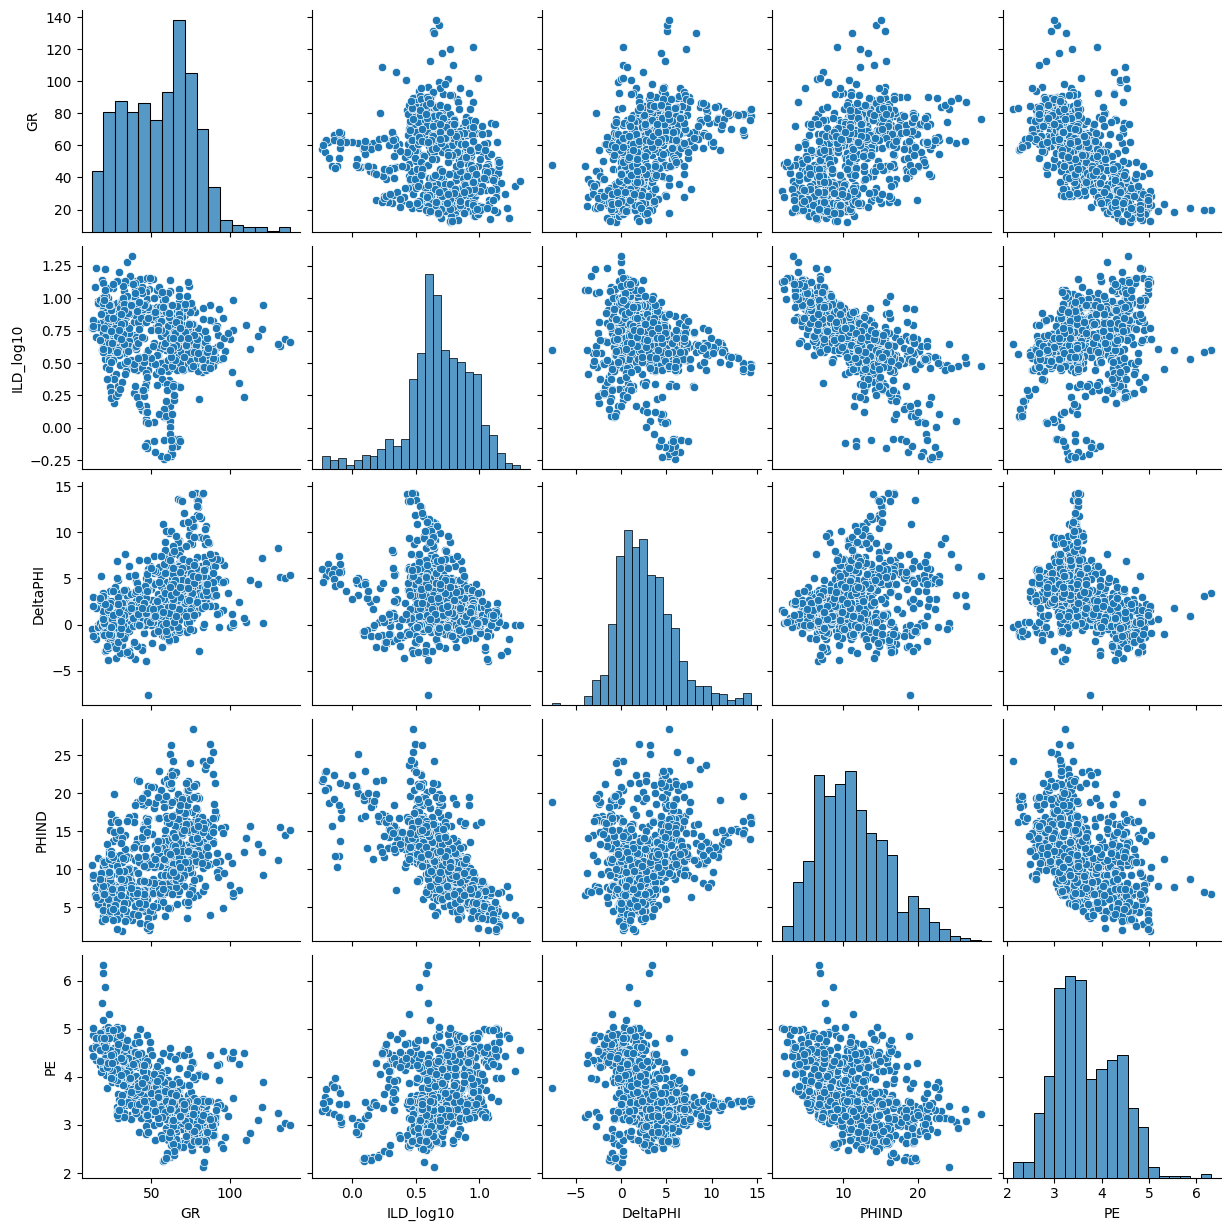

In [ ]:
# Generating the cross-plot of the data without outliers
sns.pairplot(df1)

### 1.3.3. Data Scaling

We use sklearn feature scaling, using standardscaler() method, which will transform our features into gaussian distributions
(0-mean and unit variance).

In [ ]:
# Learning the scaling from training dataset
scl = StandardScaler()
scl.fit(X_train_i)

StandardScaler()

In [ ]:
# Transforming the training and testing dataset using Standars Scaler
X_train_s = pd.DataFrame(scl.transform(X_train_i),columns=X_train_i.columns)
X_test_s  = pd.DataFrame(scl.transform(X_test_i),columns=X_test_i.columns)

In [ ]:
# Showing the descriptive statistics of the scaled training dataset
X_train_s.describe()

,GR,ILD_log10,DeltaPHI,PHIND
count,5.900000e+02,5.900000e+02,5.900000e+02,5.900000e+02
mean,3.902716e-16,-4.097005e-16,6.529617e-17,-8.089104e-17
std,1.000849e+00,1.000849e+00,1.000849e+00,1.000849e+00
min,-1.915289e+00,-3.543191e+00,-2.143982e+00,-2.019590e+00
25%,-8.391452e-01,-4.742746e-01,-7.493778e-01,-7.816888e-01
50%,8.243353e-02,-1.605498e-02,-1.186462e-01,-1.224501e-01
75%,7.462298e-01,6.683866e-01,5.728932e-01,6.572546e-01
max,3.690966e+00,2.475274e+00,3.664949e+00,3.202198e+00


In [ ]:
# Showing the descriptive statistics of the scaled testing dataset
X_test_s.describe()

,GR,ILD_log10,DeltaPHI,PHIND
count,194.000000,194.000000,194.000000,194.000000
mean,-0.014692,-0.058630,0.020514,0.000475
std,0.991981,0.985953,1.052953,1.034862
min,-1.883731,-3.188937,-3.298138,-1.962149
25%,-0.865091,-0.538772,-0.658762,-0.831418
50%,0.134326,0.007049,-0.135339,-0.100112
75%,0.716161,0.549018,0.517252,0.652468
max,2.782332,2.124871,3.664949,3.638322


Scaling looks acceptable, with standard deviation of 1 & a mean close to zero.

## 1.4 Regression Models: Optimal Hyperparameters.

I investigated five regression algorithms, performance metrics (r2 score, MAE, MSE) and selected the best algorithm based on minimum difference between memorization-generalization scores.

### 1.4.1. Preliminary Procedures
Regressors are instantiated and Crossvalidation folds created

In [ ]:
# Instantiate the Kfold CrossValidation
cv1 = KFold(n_splits=4, shuffle = True, random_state=125)

In [ ]:
# Instantiate the required regressors
en = ElasticNet()
svr = SVR()
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()
nn = MLPRegressor()

In [ ]:
# Setting up R2 criteria dataframe to evaluate memorization performance
r2_mem = pd.DataFrame(index=y_train.columns.values, columns=['EN','SVR','RFR','GBR','NN'])

# Setting up R2 criteria dataframe to evaluate generalization performance
r2_gen = pd.DataFrame(index=y_test.columns.values, columns=['EN','SVR','RFR','GBR','NN'])

### 1.4.2 Elastic Net Regressor
This regressor can work as a benchmark for the application of other more sophisticated regressors, to give an idea about performance. If performance looks ok, then we can proceed with other regressors, otherwise we can work from the features, to generate more information.

In [ ]:
# Performing hyperparameter optimization for the Elastic Net Regressor
param_grid1 = {'alpha': [0.001,0.01,0.1,1,10], 'l1_ratio': [0,0.2,0.4,0.6,0.8,1]}
grid1 = GridSearchCV(en, param_grid=param_grid1, cv=cv1, verbose=3)
grid1.fit(X_train_s, y_train_i)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV 1/4] END ...........alpha=0.001, l1_ratio=0;, score=0.440 total time=   0.0s
[CV 2/4] END ...........alpha=0.001, l1_ratio=0;, score=0.373 total time=   0.0s
[CV 3/4] END ...........alpha=0.001, l1_ratio=0;, score=0.521 total time=   0.0s
[CV 4/4] END ...........alpha=0.001, l1_ratio=0;, score=0.460 total time=   0.0s
[CV 1/4] END .........alpha=0.001, l1_ratio=0.2;, score=0.440 total time=   0.0s
[CV 2/4] END .........alpha=0.001, l1_ratio=0.2;, score=0.373 total time=   0.0s
[CV 3/4] END .........alpha=0.001, l1_ratio=0.2;, score=0.521 total time=   0.0s
[CV 4/4] END .........alpha=0.001, l1_ratio=0.2;, score=0.460 total time=   0.0s
[CV 1/4] END .........alpha=0.001, l1_ratio=0.4;, score=0.440 total time=   0.0s
[CV 2/4] END .........alpha=0.001, l1_ratio=0.4;, score=0.374 total time=   0.0s
[CV 3/4] END .........alpha=0.001, l1_ratio=0.4;, score=0.521 total time=   0.0s
[CV 4/4] END .........alpha=0.001, l1_ratio=0.4

GridSearchCV(cv=KFold(n_splits=4, random_state=125, shuffle=True),
             estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10],
                         'l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1]},
             verbose=3)

In [ ]:
# Display top 8 EN models with their associated hyperparameters
Results1 = pd.DataFrame(grid1.cv_results_)
# generate a subset of the table
Results1_tiny = Results1[['param_alpha', 'param_l1_ratio', 'mean_test_score']]
# rank them based on cross-validation scores
Results1_tiny.sort_values(by='mean_test_score', ascending=False).head(8)

,param_alpha,param_l1_ratio,mean_test_score
12,0.1,0,0.449263
6,0.01,0,0.448934
7,0.01,0.2,0.448928
8,0.01,0.4,0.448893
9,0.01,0.6,0.448828
10,0.01,0.8,0.448733
11,0.01,1,0.448607
5,0.001,1,0.448580


In [ ]:
# best/optimal hyperparameters of EN regressor
print(grid1.best_params_)

{'alpha': 0.1, 'l1_ratio': 0}


In [ ]:
# Applying the optimized EN regressor to predict the targets for the training dataset
y_pred_train1=pd.DataFrame(grid1.predict(X_train_s),columns=y_train.columns)

# Applying the optimized EN regressor to predict the targets for the testing dataset
y_pred_test1=pd.DataFrame(grid1.predict(X_test_s),columns=y_test.columns)

In [ ]:
# Memorization and generalization performances of the optimal EN regressor model
print('memorization performance of the optimal EN model (MAE): ', mean_absolute_error(y_pred_train1,y_train_i)) # memorization

print('generalization performance of the optimal EN model(MAE): ', mean_absolute_error(y_pred_test1,y_test_i))  # generalization

memorization performance of the optimal EN model (MAE):  0.3691177966700527
generalization performance of the optimal EN model(MAE):  0.3929172991121623


In [ ]:
# Filling up the memorization and generalization performances of optimized EN regressor in R2 criteria dataframe
for i, columns in enumerate(y_train.columns):
    r2_mem.EN[i]=r2_score(y_train_i[columns],y_pred_train1[columns])
    r2_gen.EN[i]=r2_score(y_test_i[columns],y_pred_test1[columns])

In [ ]:
# R2 scores for the memorization and generalization performances of the optimized EN regressor
pd.DataFrame({'EN_R2_mem': r2_mem['EN'], 'EN_R2_gen': r2_gen['EN']})

,EN_R2_mem,EN_R2_gen
PE,0.478927,0.443731


### 1.5.2 Support Vector Regressor

In [ ]:
# Performing hyperparameter optimization for the Support Vector Regressor
param_grid2 = {'kernel': ['linear','sigmoid','rbf'], 'C':[0.001,0.01,0.1,1,10,100], 'gamma':[0.1,0.5,1,5,10,15,20]}
grid2 = GridSearchCV(svr, param_grid=param_grid2, cv=cv1, verbose=3)
grid2.fit(X_train_s, y_train_i)

Fitting 4 folds for each of 126 candidates, totalling 504 fits
[CV 1/4] END .C=0.001, gamma=0.1, kernel=linear;, score=0.359 total time=   0.0s
[CV 2/4] END .C=0.001, gamma=0.1, kernel=linear;, score=0.370 total time=   0.0s
[CV 3/4] END .C=0.001, gamma=0.1, kernel=linear;, score=0.335 total time=   0.0s
[CV 4/4] END .C=0.001, gamma=0.1, kernel=linear;, score=0.392 total time=   0.0s
[CV 1/4] END C=0.001, gamma=0.1, kernel=sigmoid;, score=0.079 total time=   0.0s
[CV 2/4] END C=0.001, gamma=0.1, kernel=sigmoid;, score=0.100 total time=   0.0s
[CV 3/4] END C=0.001, gamma=0.1, kernel=sigmoid;, score=-0.073 total time=   0.0s
[CV 4/4] END C=0.001, gamma=0.1, kernel=sigmoid;, score=0.095 total time=   0.0s
[CV 1/4] END ....C=0.001, gamma=0.1, kernel=rbf;, score=0.068 total time=   0.0s
[CV 2/4] END ....C=0.001, gamma=0.1, kernel=rbf;, score=0.087 total time=   0.0s
[CV 3/4] END ...C=0.001, gamma=0.1, kernel=rbf;, score=-0.092 total time=   0.0s
[CV 4/4] END ....C=0.001, gamma=0.1, kernel=r

GridSearchCV(cv=KFold(n_splits=4, random_state=125, shuffle=True),
             estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.1, 0.5, 1, 5, 10, 15, 20],
                         'kernel': ['linear', 'sigmoid', 'rbf']},
             verbose=3)

In [ ]:
# Display top 8 SVR models with their associated hyperparameters
Results2 = pd.DataFrame(grid2.cv_results_)
# generate a subset of the table
Results2_tiny = Results2[['param_C','param_gamma','param_kernel','mean_test_score']]
# rank them based on cross-validation scores
Results2_tiny.sort_values(by='mean_test_score', ascending=False).head(8)

,param_C,param_gamma,param_kernel,mean_test_score
71,1,1,rbf,0.720042
68,1,0.5,rbf,0.708492
92,10,1,rbf,0.703892
89,10,0.5,rbf,0.687132
86,10,0.1,rbf,0.686518
107,100,0.1,rbf,0.667357
65,1,0.1,rbf,0.652199
47,0.1,0.5,rbf,0.635077


In [ ]:
# best/optimal hyperparameters of SVR -- 'C', 'gamma', 'kernel'
print(grid2.best_params_)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
# Applying the optimized SVR regressor to predict the targets for the training dataset
y_pred_train2=pd.DataFrame(grid2.predict(X_train_s),columns=y_train.columns)
# Applying the optimized SVR regressor to predict the targets for the testing dataset
y_pred_test2=pd.DataFrame(grid2.predict(X_test_s),columns=y_test.columns)

In [ ]:
# Memorization and generalization performances of the optimal SV regressor model

print('memorization performance of the optimal SVR model (MAE): ', mean_absolute_error(y_pred_train2,y_train_i)) # memorization

print('generalization performance of the optimal SVR model (MAE): ', mean_absolute_error(y_pred_test2,y_test_i))  # generalization

memorization performance of the optimal SVR model:  0.16581173630574086
generalization performance of the optimal SVR model:  0.24464696297416624


In [ ]:
# Filling up the memorization and generalization performances of optimized SVR regressor in R2 criteria dataframe
for i, columns in enumerate(y_train.columns):
    r2_mem.SVR[i]=r2_score(y_train_i[columns],y_pred_train2[columns])
    r2_gen.SVR[i]=r2_score(y_test_i[columns],y_pred_test2[columns])

In [ ]:
# R2 scores for the memorization and generalization performances of the optimized SVR regressor

pd.DataFrame({'SVR_R2_mem': r2_mem['SVR'], 'SVR_R2_gen': r2_gen['SVR']})

,SVR_R2_mem,SVR_R2_gen
PE,0.858577,0.736116


### 1.4.3 Random Forest Regressor

In [ ]:
# Performing hyperparameter optimization for the Random Forest Regressor
param_grid3 = {'min_samples_leaf':[1,3,5], 'max_depth':[2,4,6,8], 'max_features':[2,3,4,5], 'n_estimators':[50,100,150,200,250]}
grid3 = GridSearchCV(rfr, param_grid=param_grid3, cv=cv1, verbose=3)
grid3.fit(X_train_s, y_train_i)

Fitting 4 folds for each of 240 candidates, totalling 960 fits
[CV 1/4] END max_depth=2, max_features=2, min_samples_leaf=1, n_estimators=50;, score=0.523 total time=   0.1s
[CV 2/4] END max_depth=2, max_features=2, min_samples_leaf=1, n_estimators=50;, score=0.499 total time=   0.1s
[CV 3/4] END max_depth=2, max_features=2, min_samples_leaf=1, n_estimators=50;, score=0.556 total time=   0.1s
[CV 4/4] END max_depth=2, max_features=2, min_samples_leaf=1, n_estimators=50;, score=0.555 total time=   0.1s
[CV 1/4] END max_depth=2, max_features=2, min_samples_leaf=1, n_estimators=100;, score=0.524 total time=   0.1s
[CV 2/4] END max_depth=2, max_features=2, min_samples_leaf=1, n_estimators=100;, score=0.490 total time=   0.1s
[CV 3/4] END max_depth=2, max_features=2, min_samples_leaf=1, n_estimators=100;, score=0.555 total time=   0.1s
[CV 4/4] END max_depth=2, max_features=2, min_samples_leaf=1, n_estimators=100;, score=0.545 total time=   0.2s
[CV 1/4] END max_depth=2, max_features=2, min

GridSearchCV(cv=KFold(n_splits=4, random_state=125, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8],
                         'max_features': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [50, 100, 150, 200, 250]},
             verbose=3)

In [ ]:
# Display top 8 RFR models with their associated hyperparameters
Results3 = pd.DataFrame(grid3.cv_results_)
# generate a subset of the table
Results3_tiny = Results3[['param_min_samples_leaf','param_max_depth', 'param_max_features', 'param_n_estimators',  'mean_test_score']]
# rank them based on cross-validation scores
Results3_tiny.sort_values(by='mean_test_score', ascending=False).head(8)

,param_min_samples_leaf,param_max_depth,param_max_features,param_n_estimators,mean_test_score
195,1,8,3,50,0.729301
184,1,8,2,250,0.721691
196,1,8,3,100,0.721591
198,1,8,3,200,0.721117
199,1,8,3,250,0.720566
181,1,8,2,100,0.720460
182,1,8,2,150,0.719975
213,1,8,4,200,0.718173


In [ ]:
# best/optimal hyperparameters of RF regressor
print(grid3.best_params_)

{'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 50}


In [ ]:
# Applying the optimized RF regressor to predict the targets for the training dataset
y_pred_train3=pd.DataFrame(grid3.predict(X_train_s),columns=y_train.columns)
# Applying the optimized RF regressor to predict the targets for the testing dataset
y_pred_test3=pd.DataFrame(grid3.predict(X_test_s),columns=y_test.columns)

In [ ]:
# Memorization and generalization performances of the optimal RF regressor model

print('memorization performance of the optimal RFR model (MAE): ', mean_absolute_error(y_pred_train3,y_train_i)) # memorization

print('generalization performance of the optimal RFR model (MAE): ', mean_absolute_error(y_pred_test3,y_test_i))  # generalization

memorization performance of the optimal RFR model:  0.14554260935582358
generalization performance of the optimal RFR model:  0.25846688256959677


In [ ]:
# Filling up the memorization and generalization performances of optimized RF regressor in R2 criteria dataframe
for i, columns in enumerate(y_train.columns):
    r2_mem.RFR[i]=r2_score(y_train_i[columns],y_pred_train3[columns])
    r2_gen.RFR[i]=r2_score(y_test_i[columns],y_pred_test3[columns])

In [ ]:
# R2 scores for the memorization and generalization performances of the optimized RF regressor

pd.DataFrame({'RFR_R2_mem': r2_mem['RFR'], 'RFR_R2_gen': r2_gen['RFR']})

,RFR_R2_mem,RFR_R2_gen
PE,0.90811,0.733239


### 1.4.4 Gradient Boosting Regressor

In [ ]:
# Performing hyperparameter optimization for the Gradient Boosting Regressor
param_grid4 = {'estimator__min_samples_leaf':[1,3,5], 'estimator__max_depth':[2,4,6,8], 'estimator__max_features':[2,3,4,5], 'estimator__n_estimators':[50,100,150,200,250]}
grid4 = GridSearchCV(MultiOutputRegressor(gbr), param_grid=param_grid4, cv=cv1, verbose=3)
grid4.fit(X_train_s, y_train_i)

Fitting 4 folds for each of 240 candidates, totalling 960 fits
[CV 1/4] END estimator__max_depth=2, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__n_estimators=50;, score=0.574 total time=   0.0s
[CV 2/4] END estimator__max_depth=2, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__n_estimators=50;, score=0.583 total time=   0.0s
[CV 3/4] END estimator__max_depth=2, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__n_estimators=50;, score=0.666 total time=   0.0s
[CV 4/4] END estimator__max_depth=2, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__n_estimators=50;, score=0.634 total time=   0.0s
[CV 1/4] END estimator__max_depth=2, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__n_estimators=100;, score=0.599 total time=   0.1s
[CV 2/4] END estimator__max_depth=2, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__n_estimators=100;, score=0.620 total time=   0.1s
[CV 3

GridSearchCV(cv=KFold(n_splits=4, random_state=125, shuffle=True),
             estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor()),
             param_grid={'estimator__max_depth': [2, 4, 6, 8],
                         'estimator__max_features': [2, 3, 4, 5],
                         'estimator__min_samples_leaf': [1, 3, 5],
                         'estimator__n_estimators': [50, 100, 150, 200, 250]},
             verbose=3)

In [ ]:
# Display top 8 GBR models with their associated hyperparameters
Results4 = pd.DataFrame(grid4.cv_results_)
# generate a subset of the table
Results4_tiny = Results4[['param_estimator__min_samples_leaf','param_estimator__max_depth', 'param_estimator__max_features', 'param_estimator__n_estimators',  'mean_test_score']]
# rank them based on cross-validation scores
Results4_tiny.sort_values(by='mean_test_score', ascending=False).head(8)

,param_estimator__min_samples_leaf,param_estimator__max_depth,param_estimator__max_features,param_estimator__n_estimators,mean_test_score
124,1,6,2,250,0.735627
184,1,8,2,250,0.734875
180,1,8,2,50,0.734603
188,3,8,2,200,0.734028
187,3,8,2,150,0.733642
189,3,8,2,250,0.732500
138,1,6,3,200,0.732246
182,1,8,2,150,0.732076


In [ ]:
# best/optimal hyperparameters of GB regressor
print(grid4.best_params_)

{'estimator__max_depth': 6, 'estimator__max_features': 2, 'estimator__min_samples_leaf': 1, 'estimator__n_estimators': 250}


In [ ]:
# Applying the optimized GB regressor to predict the targets for the training dataset
y_pred_train4=pd.DataFrame(grid4.predict(X_train_s),columns=y_train.columns)
# Applying the optimized GB regressor to predict the targets for the testing dataset
y_pred_test4=pd.DataFrame(grid4.predict(X_test_s),columns=y_test.columns)

In [ ]:
# Memorization and generalization performances of the optimal RF regressor model

print('memorization performance of the optimal GBR model (MAE): ', mean_absolute_error(y_pred_train4,y_train_i)) # memorization

print('generalization performance of the optimal GBR model (MAE): ', mean_absolute_error(y_pred_test4,y_test_i))  # generalization

memorization performance of the optimal GBR model (MAE):  0.00928809232313671
generalization performance of the optimal GBR model (MAE):  0.24611763587843472


In [ ]:
# Filling up the memorization and generalization performances of optimized GB regressor in R2 criteria dataframe
for i, columns in enumerate(y_train.columns):
    r2_mem.GBR[i]=r2_score(y_train_i[columns],y_pred_train4[columns])
    r2_gen.GBR[i]=r2_score(y_test_i[columns],y_pred_test4[columns])

In [ ]:
# R2 scores for the memorization and generalization performances of the optimized GB regressor

pd.DataFrame({'GBR_R2_mem': r2_mem['GBR'], 'GBR_R2_gen': r2_gen['GBR']})

,GBR_R2_mem,GBR_R2_gen
PE,0.99963,0.747578


In [ ]:
# Performing hyperparameter optimization for the Neural Network Regressor
param_grid5 = {'hidden_layer_sizes':[(80),(100),(120),(150)], 'batch_size':[int(len(X_train_s)/15),int(len(X_train_s)/10),int(len(X_train_s)/5)], 'learning_rate':['constant','invscaling','adaptive'], 'alpha':[0.0001,0.001,0.01], 'solver':['lbfgs'], 'max_iter':[3000], 'early_stopping':[True]}
grid5 = GridSearchCV(nn, param_grid=param_grid5, cv=cv1, verbose=3)
grid5.fit(X_train_s, y_train_i)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
[CV 1/4] END alpha=0.0001, batch_size=39, early_stopping=True, hidden_layer_sizes=80, learning_rate=constant, max_iter=3000, solver=lbfgs;, score=0.512 total time=   5.2s
[CV 2/4] END alpha=0.0001, batch_size=39, early_stopping=True, hidden_layer_sizes=80, learning_rate=constant, max_iter=3000, solver=lbfgs;, score=-0.102 total time=   5.1s
[CV 3/4] END alpha=0.0001, batch_size=39, early_stopping=True, hidden_layer_sizes=80, learning_rate=constant, max_iter=3000, solver=lbfgs;, score=0.387 total time=   5.2s
[CV 4/4] END alpha=0.0001, batch_size=39, early_stopping=True, hidden_layer_sizes=80, learning_rate=constant, max_iter=3000, solver=lbfgs;, score=0.173 total time=   5.2s
[CV 1/4] END alpha=0.0001, batch_size=39, early_stopping=True, hidden_layer_sizes=80, learning_rate=invscaling, max_iter=3000, solver=lbfgs;, score=0.456 total time=   3.7s
[CV 2/4] END alpha=0.0001, batch_size=39, early_stopping=True, hidden_layer_siz

GridSearchCV(cv=KFold(n_splits=4, random_state=125, shuffle=True),
             estimator=MLPRegressor(),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'batch_size': [39, 59, 118], 'early_stopping': [True],
                         'hidden_layer_sizes': [80, 100, 120, 150],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [3000], 'solver': ['lbfgs']},
             verbose=3)

In [ ]:
# Display top 8 NN models with their associated hyperparameters
Results5 = pd.DataFrame(grid5.cv_results_)
# generate a subset of the table
Results5_tiny = Results5[['param_hidden_layer_sizes','param_batch_size', 'param_learning_rate', 'param_alpha',  'mean_test_score']]
# rank them based on cross-validation scores
Results5_tiny.sort_values(by='mean_test_score', ascending=False).head(8)

,param_hidden_layer_sizes,param_batch_size,param_learning_rate,param_alpha,mean_test_score
105,150,118,constant,0.01,0.560283
107,150,118,adaptive,0.01,0.560189
96,80,118,constant,0.01,0.532572
88,100,59,invscaling,0.01,0.529792
90,120,59,constant,0.01,0.524492
91,120,59,invscaling,0.01,0.521625
98,80,118,adaptive,0.01,0.520685
95,150,59,adaptive,0.01,0.515127


In [ ]:
# best/optimal hyperparameters of NN regressor
print(grid5.best_params_)

{'alpha': 0.01, 'batch_size': 118, 'early_stopping': True, 'hidden_layer_sizes': 150, 'learning_rate': 'constant', 'max_iter': 3000, 'solver': 'lbfgs'}


In [ ]:
# Applying the optimized NN regressor to predict the targets for the training dataset
y_pred_train5=pd.DataFrame(grid5.predict(X_train_s),columns=y_train.columns)
# Applying the optimized NN regressor to predict the targets for the testing dataset
y_pred_test5=pd.DataFrame(grid5.predict(X_test_s),columns=y_test.columns)

In [ ]:
# Memorization and generalization performances of the optimal RF regressor model

print('memorization performance of the optimal GBR model (MAE): ', mean_absolute_error(y_pred_train5,y_train_i)) # memorization

print('generalization performance of the optimal GBR model (MAE): ', mean_absolute_error(y_pred_test5,y_test_i))  # generalization

memorization performance of the optimal GBR model (MAE):  0.050171868304889206
generalization performance of the optimal GBR model (MAE):  0.3764417041326891


In [ ]:
# Filling up the memorization and generalization performances of optimized NN regressor in R2 criteria dataframe
for i, columns in enumerate(y_train.columns):
    r2_mem.NN[i]=r2_score(y_train_i[columns],y_pred_train5[columns])
    r2_gen.NN[i]=r2_score(y_test_i[columns],y_pred_test5[columns])

In [ ]:
# R2 scores for the memorization and generalization performances of the optimized NN regressor

pd.DataFrame({'NN_R2_mem': r2_mem['NN'], 'NN_R2_gen': r2_gen['NN']})

,NN_R2_mem,NN_R2_gen
PE,0.984254,0.198777


## 1.5 Optimal Regressor & Performance Metrics Selection

---

We select memorization & Generalization performance of different Data-Driven Models.

### 1.5.1 Visualization of regressors results

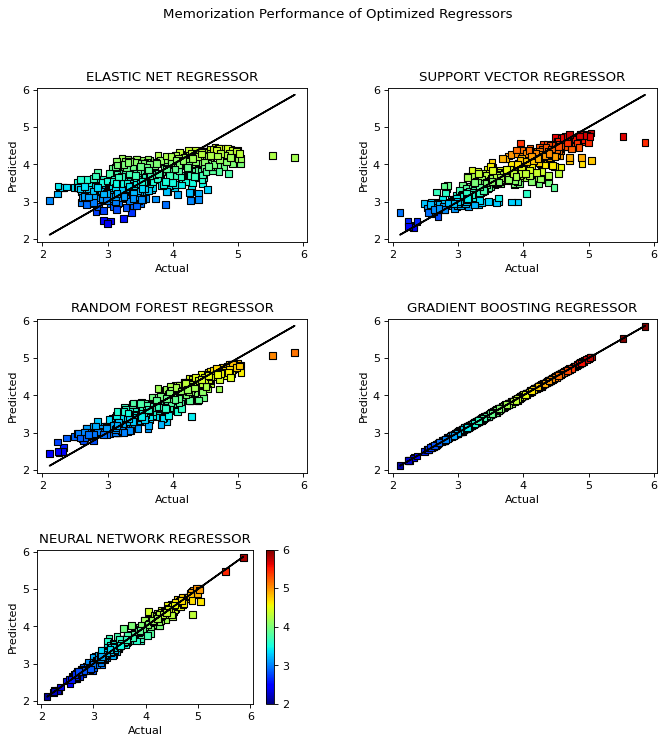

In [ ]:
# Visualization of the memorization performance of the regressors on training dataset

fig, axes = plt.subplots(nrows=3, ncols=2, dpi = 80, figsize=(10,10))
fig.suptitle('Memorization Performance of Optimized Regressors')
fig.subplots_adjust(wspace=0.3,hspace=0.5)
cm = plt.cm.get_cmap('jet')

axes[0,0].set(title='ELASTIC NET REGRESSOR')
axes[0,1].set(title='SUPPORT VECTOR REGRESSOR')
axes[1,0].set(title='RANDOM FOREST REGRESSOR')
axes[1,1].set(title='GRADIENT BOOSTING REGRESSOR')
axes[2,0].set(title='NEURAL NETWORK REGRESSOR')
fig.delaxes(axes[2,1])

axes[0,0].scatter(y_train_i, y_pred_train1, c=y_pred_train1.PE, vmin=int(y_pred_train1.min()), vmax=int(y_pred_train5.max())+1, marker='s', edgecolors='black', cmap=cm)
axes[0,0].plot(y_train_i, y_train_i, c='black')
axes[0,0].set_xlabel('Actual')
axes[0,0].set_ylabel('Predicted')

axes[0,1].scatter(y_train_i, y_pred_train2, c=y_pred_train2.PE, vmin=int(y_pred_train2.min()), vmax=int(y_pred_train2.max())+1, marker='s', edgecolors='black', cmap=cm)
axes[0,1].plot(y_train_i, y_train_i, c='black')
axes[0,1].set_xlabel('Actual')
axes[0,1].set_ylabel('Predicted')

axes[1,0].scatter(y_train_i, y_pred_train3, c=y_pred_train3.PE, vmin=int(y_pred_train3.min()), vmax=int(y_pred_train3.max())+1, marker='s', edgecolors='black', cmap=cm)
axes[1,0].plot(y_train_i, y_train_i, c='black')
axes[1,0].set_xlabel('Actual')
axes[1,0].set_ylabel('Predicted')

axes[1,1].scatter(y_train_i, y_pred_train4, c=y_pred_train4.PE, vmin=int(y_pred_train4.min()), vmax=int(y_pred_train4.max())+0.2, marker='s', edgecolors='black', cmap=cm)
axes[1,1].plot(y_train_i, y_train_i, c='black')
axes[1,1].set_xlabel('Actual')
axes[1,1].set_ylabel('Predicted')

pl = axes[2,0].scatter(y_train_i, y_pred_train5, c=y_pred_train5.PE, vmin=int(y_pred_train5.min()), vmax=int(y_pred_train5.max())+1, marker='s', edgecolors='black', cmap=cm)
axes[2,0].plot(y_train_i, y_train_i, c='black')
axes[2,0].set_xlabel('Actual')
axes[2,0].set_ylabel('Predicted')

fig.colorbar(pl)
# fig.tight_layout()

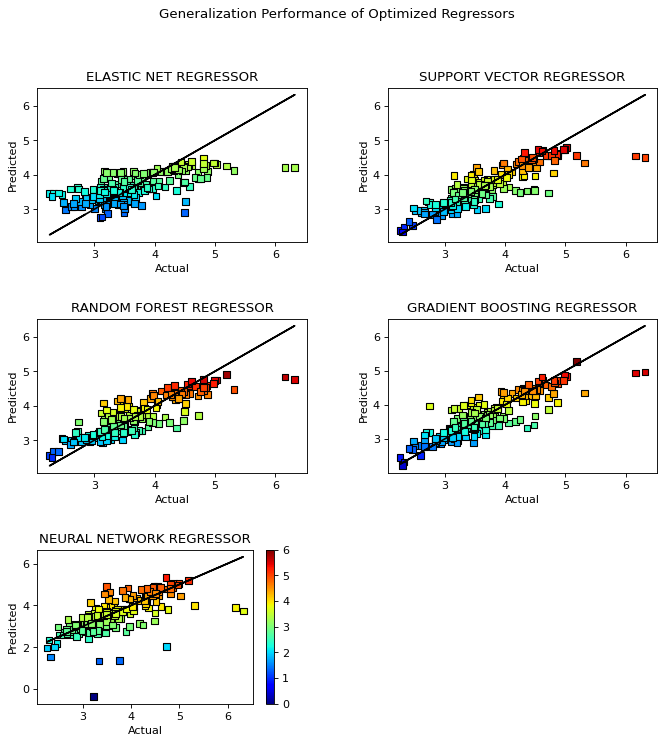

In [ ]:
# Visualization of the generalization performance of the regressors on testing dataset

fig, axes = plt.subplots(nrows=3, ncols=2, dpi = 80, figsize=(10,10))
fig.suptitle('Generalization Performance of Optimized Regressors')
fig.subplots_adjust(wspace=0.3,hspace=0.5)
cm = plt.cm.get_cmap('jet')

axes[0,0].set(title='ELASTIC NET REGRESSOR')
axes[0,1].set(title='SUPPORT VECTOR REGRESSOR')
axes[1,0].set(title='RANDOM FOREST REGRESSOR')
axes[1,1].set(title='GRADIENT BOOSTING REGRESSOR')
axes[2,0].set(title='NEURAL NETWORK REGRESSOR')
fig.delaxes(axes[2,1])

axes[0,0].scatter(y_test_i, y_pred_test1, c=y_pred_test1.PE, vmin=int(y_pred_test1.min()), vmax=int(y_pred_test5.max())+1, marker='s', edgecolors='black', cmap=cm)
axes[0,0].plot(y_test_i, y_test_i, c='black')
axes[0,0].set_xlabel('Actual')
axes[0,0].set_ylabel('Predicted')

axes[0,1].scatter(y_test_i, y_pred_test2, c=y_pred_test2.PE, vmin=int(y_pred_test2.min()), vmax=int(y_pred_test2.max())+1, marker='s', edgecolors='black', cmap=cm)
axes[0,1].plot(y_test_i, y_test_i, c='black')
axes[0,1].set_xlabel('Actual')
axes[0,1].set_ylabel('Predicted')

axes[1,0].scatter(y_test_i, y_pred_test3, c=y_pred_test3.PE, vmin=int(y_pred_test3.min()), vmax=int(y_pred_test3.max())+1, marker='s', edgecolors='black', cmap=cm)
axes[1,0].plot(y_test_i, y_test_i, c='black')
axes[1,0].set_xlabel('Actual')
axes[1,0].set_ylabel('Predicted')

axes[1,1].scatter(y_test_i, y_pred_test4, c=y_pred_test4.PE, vmin=int(y_pred_test4.min()), vmax=int(y_pred_test4.max())+0.2, marker='s', edgecolors='black', cmap=cm)
axes[1,1].plot(y_test_i, y_test_i, c='black')
axes[1,1].set_xlabel('Actual')
axes[1,1].set_ylabel('Predicted')

pl = axes[2,0].scatter(y_test_i, y_pred_test5, c=y_pred_test5.PE, vmin=int(y_pred_test5.min()), vmax=int(y_pred_test5.max())+1, marker='s', edgecolors='black', cmap=cm)
axes[2,0].plot(y_test_i, y_test_i, c='black')
axes[2,0].set_xlabel('Actual')
axes[2,0].set_ylabel('Predicted')

fig.colorbar(pl)
# fig.tight_layout()

In [ ]:
# Memorization performance of differnet regression models
r2_mem

,EN,SVR,RFR,GBR,NN
PE,0.478927,0.858577,0.90811,0.99963,0.984254


<function matplotlib.pyplot.show>

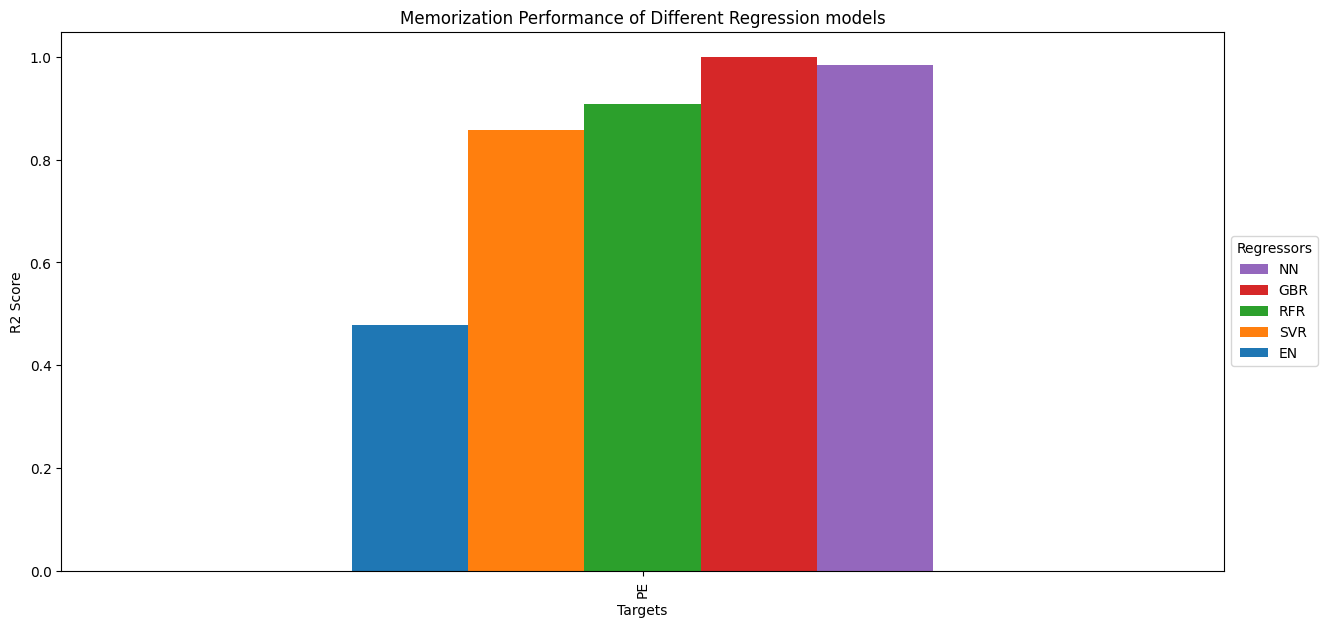

In [ ]:
# Visualization of memorization performance of differnet regression models
ax = r2_mem.plot.bar(stacked=False,title='Memorization Performance of Different Regression models',figsize=(15,7))
plt.xlabel('Targets')
plt.ylabel('R2 Score')
plt.ylim(bottom=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Regressors', loc='center left', bbox_to_anchor=(1,.5))
plt.show

In [ ]:
# Generalization performance of differnet regression models
r2_gen

,EN,SVR,RFR,GBR,NN
PE,0.443731,0.736116,0.733239,0.747578,0.198777


<function matplotlib.pyplot.show>

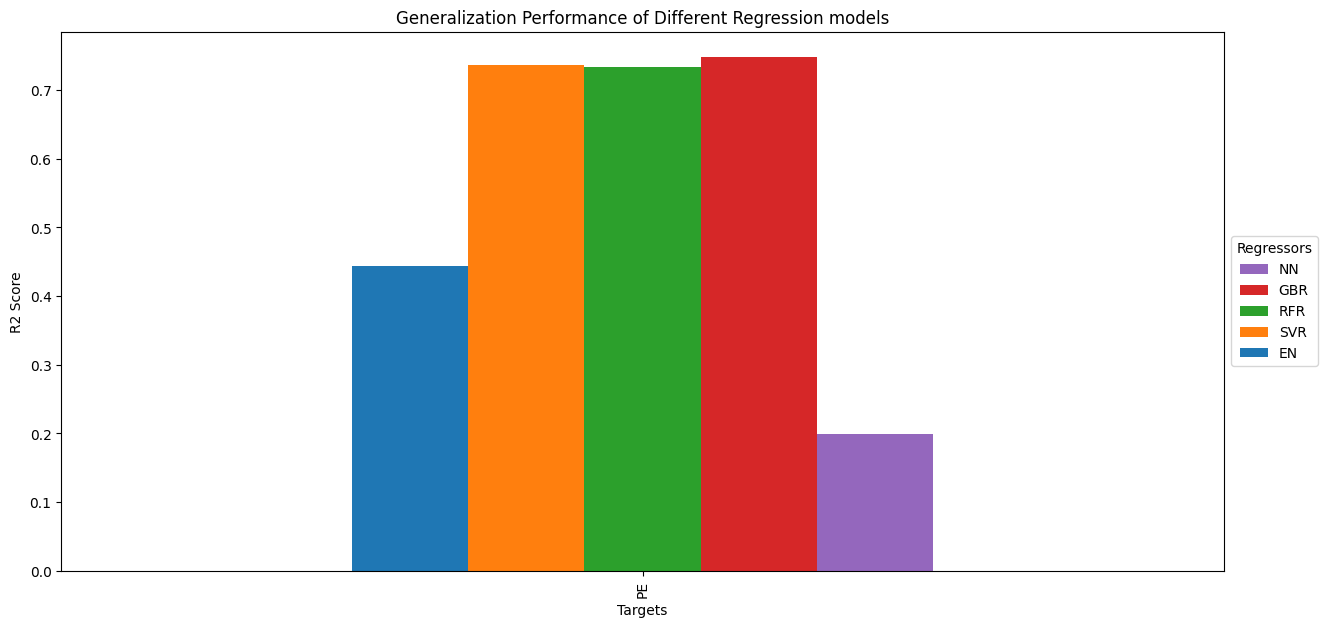

In [ ]:
# Visualization of generalization performance of differnet regression models
ax = r2_gen.plot.bar(stacked=False,title='Generalization Performance of Different Regression models',figsize=(15,7))
plt.xlabel('Targets')
plt.ylabel('R2 Score')
plt.ylim(bottom=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Regressors', loc='center left', bbox_to_anchor=(1,.5))
plt.show

In [ ]:
# Summarizing the results in a single dataframe by calculating the mean of each regressor.
# Sorting the regressors based on their generalization performance.
summary = pd.DataFrame(r2_gen.mean(axis=0),columns=['Mean_R2_gen']).sort_values(by='Mean_R2_gen', ascending=False)
summary

,Mean_R2_gen
GBR,0.747578
SVR,0.736116
RFR,0.733239
EN,0.443731
NN,0.198777


## 1.5.2. Selection of Three Best Models

In [ ]:
# Results sorted based on the mean of R2 generalization scores
summary

,Mean_R2_gen
GBR,0.747578
SVR,0.736116
RFR,0.733239
EN,0.443731
NN,0.198777


In [ ]:
# Selecting the first best model
if summary.iloc[0].name == 'EN':
    model1st = grid1
elif summary.iloc[0].name == 'SVR':
    model1st = grid2
elif summary.iloc[0].name == 'RFR':
    model1st = grid3
elif summary.iloc[0].name == 'GBR':
    model1st = grid4
elif summary.iloc[0].name == 'NN':
    model1st = grid5

# Selecting the second best model
if summary.iloc[1].name == 'EN':
    model2nd = grid1
elif summary.iloc[1].name == 'SVR':
    model2nd = grid2
elif summary.iloc[1].name == 'RFR':
    model2nd = grid3
elif summary.iloc[1].name == 'GBR':
    model2nd = grid4
elif summary.iloc[1].name == 'NN':
    model2nd = grid5

# Selecting the third best model
if summary.iloc[2].name == 'EN':
    model3rd = grid1
elif summary.iloc[2].name == 'SVR':
    model3rd = grid2
elif summary.iloc[2].name == 'RFR':
    model3rd = grid3
elif summary.iloc[2].name == 'GBR':
    model3rd = grid4
elif summary.iloc[2].name == 'NN':
    model3rd = grid5

### 1.7 Deployment on  Well

---

We will deploy results visually on log tracks and check logs correspondance

In [ ]:
# Comparing between the true data and the predictions for the well
y_svr = np.vstack([y_pred_train2,y_pred_test2])
y_rfr = np.vstack([y_pred_train3,y_pred_test3])
y_gbr = np.vstack([y_pred_train4,y_pred_test4])
y_nn = np.vstack([y_pred_train5,y_pred_test5])

In [ ]:
df1['PE_SVR'] = y_svr
df1['PE_RFR'] = y_rfr
df1['PE_GBR'] = y_gbr
df1['PE_NN'] = y_nn

In [ ]:
%matplotlib inline
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

def make_log_plot2(logs):
    #make sure logs are sorted by depth
    logs.sort_index(inplace=True)
    logs.Depth = np.array(logs.index)
    ztop=logs.Depth.min(); zbot=logs.Depth.max()

    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-k')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '--b')
    ax[3].plot(logs.PHIND, logs.Depth, '-r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    ax[5].plot(logs.PE_SVR, logs.Depth, '-', color='purple')
    ax2 = ax[5].twiny() # Nuevo objeto Axes, gemelo de ax1.
    ax2.plot(logs.PE_RFR, logs.Depth, '--', color='cyan')
    ax[6].plot(logs.PE_GBR, logs.Depth, '-', color='slateblue')
    ax3 = ax[6].twiny() # Nuevo objeto Axes, gemelo de ax1.
    ax3.plot(logs.PE_NN, logs.Depth, '--', color='darkorange')

#     divider = make_axes_locatable(ax[5])
#     cax = divider.append_axes("right", size="20%", pad=0.05)

    for i in range(len(ax)):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel("PE_SVR")
    ax[5].set_xlim(logs.PE_SVR.min(),logs.PE_SVR.max())
    ax2.set_xlabel("PE_RFR")
    ax2.set_xlim(logs.PE_RFR.min(),logs.PE_RFR.max())
    ax2.spines['bottom'].set_color('purple') # Eje inferior.
    ax2.spines['top'].set_color('cyan')     # Eje superior.
    ax[6].set_xlabel("PE_GBR")
    ax[6].set_xlim(logs.PE_GBR.min(),logs.PE_GBR.max())
    ax3.set_xlabel("PE_pred_NN")
    ax3.set_xlim(logs.PE_NN.min(),logs.PE_NN.max())
    ax3.spines['bottom'].set_color('slateblue') # Eje inferior.
    ax3.spines['top'].set_color('darkorange')     # Eje superior.

    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]);ax[6].set_yticklabels([]);

    f.suptitle('Well: SEG_DATA WELL', fontsize=14,y=0.94)

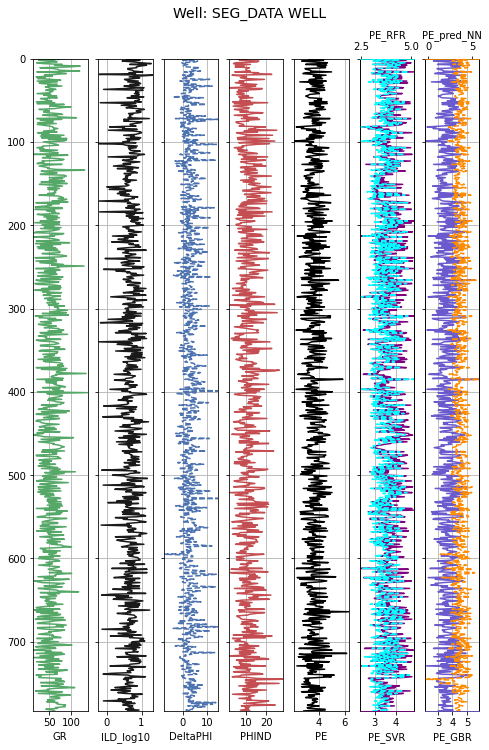

In [ ]:
make_log_plot2(df1)

From the Predicted PE logs signatures, we observe a somewhat acceptable results in most of the intervals trained. However NN is performing poorly.

## <b>Conclusions</b>

*   PE log are predicted using ElasticNet, Support vector Regressor, Random Forest, Gradient Boosting, Neural Networks algorithm, with a r2 score ranging from 0.47-0.99 for training and r2 score ranging from 0.2-0.75 for testing data.

* Best regressor was Gradient Boosting, after  hyperparameters optimization implementation. The r2 scores were 0.99 for training and 0.75 for testing phase. The algorithm is clearly overfitting.

*   Hyperparameters optimized for the best regressor includes Number of estimators (250) and Max. Depth of trees (6) and maximum number of features to sample (2) and min samples leaf for splitting a node (1).

*   Among performance Metrics during the optimization, r2 scores seems to work just fine. Mean Absolute error and Mean Square error were computed, but as of writing this report, no apparent benefit is observed from using one metric or the others.


## <b>References</b>


1.   SPE Glossary, https://petrowiki.spe.org/Category:Glossary
2.   Schlumberger glossary, https://glossary.oilfield.slb.com/en/
3.   Hall, Brendon. Facies classification using machine learning. https://library.seg.org/doi/10.1190/tle35100906.1
4.   Yunxin Xie, Chenyang Zhu et al. Evaluation of machine learning methods for formation lithology identification: A comparison of tuning processes and model performances https://www.sciencedirect.com/science/article/pii/S0920410517308094
5.   Yunxin Xie, Chenyang Zhu et al. Evaluation of machine learning methods for formation lithology identification: A comparison of tuning processes and model performances https://www.sciencedirect.com/science/article/pii/S0920410517308094
6.   Calle Restrepo Felipe, et al. MLDS UNAL course python Notebooks from units-3-4.
7. Misra, Siddarth. PETE-689-Petroleum Data Analytics & machine learning Course Materials. Texas A&M  University. Spring 2022
8.   Fabio Augusto Gonzalez, et al. MLDS UNAL course python Notebooks from units-1-2-3.






